# Preambule

## libraries

In [1]:
library(tidyverse)
library(stringr)
library(caret)
library(data.table)
library(stringr)
library(dplyr)
library(qs)
library(parallel)
library(randomForest)
library(inTrees)
library(endoR)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


qs v0.23.4.

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package

In [2]:
library(viridis)

Loading required package: viridisLite



In [3]:
library(ggpubr)

In [4]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/Methanogen_SCFA/Metagenomes_methanogen/envs/r-ml/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggpubr_0.4.0        viridis_0.5.1       viridisLite_0.3.0  
 [4] endoR_0.1.0         inTrees_1.3         randomForest_4.6-14
 [7] qs_0.23.4           data.table_1.13.4   caret_6.0-86       
[10] lattice_0.20-41     forcats_0.5.0       stringr_1.4.0    

## functions

In [5]:
file.sources <- list.files('./scripts/', pattern = '*.R', full.names=TRUE, ignore.case=TRUE)
for (f in file.sources) {
    source(f)
}
rm('file.sources', 'f')

In [6]:
getRes <- function(path, p = NULL, true_edges){
    fnames <- list.files(path = path, full.names = TRUE, pattern = 'simu')
    seedN <- as.numeric(str_extract(fnames, pattern = '(?<=simu)[:digit:]+'))
    fnames <- fnames[which(seedN %in% 1733:1832)]
    
    res <- list()
    for (i in 1:length(fnames)){
        tmp <- qread(fnames[i])
        
        # get the new metrics
        quiet(pc <- stabilitySelection(tmp$resamp, alpha_error = 5, pi_thr = 0.7))
        
        cond <- pc$rules_summary %>% subset(inN >= 7, select = condition) %>% unlist
        
        if (length(cond) > 0 & ('edges_agg' %in% names(pc))){
            
            imp_edges <- pc$edges_agg %>% subset(condition %in% cond) %>% select(x,y, importance, n, imp)
            imp_edges$x <- str_replace(imp_edges$x, pattern = '\\_{2}.*', replacement = '')
            imp_edges$y <- str_replace(imp_edges$y, pattern = '\\_{2}.*', replacement = '')
            suppressMessages(imp_edges <- imp_edges %>% group_by(x,y) %>% summarise(importance = sum(n*imp*importance)))
            imp_edges <- asplit(as.matrix(imp_edges), MARGIN = 1)
            imp_edges <- lapply(imp_edges, sort) 
            pred_edges <- sapply(imp_edges, function(x){paste(x[-1], collapse = ' - ')}) 

            # those that should not be but are = in pred_edges but not truth
            tp <- which(sapply(pred_edges, function(x){x %in% true_edges}))
            fp <- which(sapply(pred_edges, function(x){!(x %in% true_edges)}))
            fn <- sum(sapply(true_edges, function(x){!(x %in% pred_edges)}))

            # sum of FP importances
            if(length(fp) > 0) {
                fp_imp <- sum(sapply(imp_edges[fp], function(x){as.numeric(x['importance'])}))
            } else {fp_imp <- 0}
            # sum of TP importances
            if(length(tp) > 0) {
                tp_imp <- sum(sapply(imp_edges[tp], function(x){as.numeric(x['importance'])}))
            } else {tp_imp <- 0}

            res[[i]] <- c('rf_accuracy' = tmp$rf_accuracy, 'n_decisions' = length(cond)
                          , 'tp_imp' = tp_imp, 'fp_imp' = fp_imp, 'tp' = length(tp), 'fp' = length(fp)
                          , 'fn' = fn)
        } else {
            res[[i]] <- c('rf_accuracy' = tmp$rf_accuracy, 'n_decisions' = 0
                          , 'tp_imp' = 0, 'fp_imp' = 0, 'tp' = 0, 'fp' = 0, 'fn' = 0)
        }
        
    }
    res <- as.data.frame(do.call(rbind, res))
    
    nt <- as.numeric(str_extract(path, pattern = '(?<=\\_ntree)[:digit:]+'))
    if (is.na(nt)) nt <- 500
    res$ntree <- nt
    
    return(res)
}

# Run

In [7]:
true_edges <- qread('true_edges.qs')
true_edges <- true_edges %>% lapply(sort) %>% sapply(paste, collapse = ' - ')

In [8]:
fnames <- list.dirs(path = '/ebio/abt3_projects/temp_data/aruaud/', full.names = TRUE)
fnames <- str_subset(fnames, pattern = 'Toy\\_p005+\\_N1000\\_B10(?=$|\\_)')
fnames

[1] "/ebio/abt3_projects/temp_data/aruaud//Toy_p005_N1000_B10"         
[2] "/ebio/abt3_projects/temp_data/aruaud//Toy_p005_N1000_B10_ntree10" 
[3] "/ebio/abt3_projects/temp_data/aruaud//Toy_p005_N1000_B10_ntree100"

In [9]:
res <- lapply(fnames, getRes, true_edges = true_edges)
res <- do.call(rbind, res)

Warning message in stabilitySelection(tmp$resamp, alpha_error = 5, pi_thr = 0.7):
“No stable decision ensemble could be reached: try increasing alpha.”
Warning message in stabilitySelection(tmp$resamp, alpha_error = 5, pi_thr = 0.7):
“No stable decision ensemble could be reached: try increasing alpha.”
Warning message in stabilitySelection(tmp$resamp, alpha_error = 5, pi_thr = 0.7):
“No stable decision ensemble could be reached: try increasing alpha.”
Warning message in stabilitySelection(tmp$resamp, alpha_error = 5, pi_thr = 0.7):
“No stable decision ensemble could be reached: try increasing alpha.”
Warning message in stabilitySelection(tmp$resamp, alpha_error = 5, pi_thr = 0.7):
“No stable decision ensemble could be reached: try increasing alpha.”
Warning message in stabilitySelection(tmp$resamp, alpha_error = 5, pi_thr = 0.7):
“No stable decision ensemble could be reached: try increasing alpha.”
Warning message in stabilitySelection(tmp$resamp, alpha_error = 5, pi_thr = 0.7):
“No st

In [10]:
res$precision <- res$tp/(res$tp+res$fp)
res$recall <- res$tp/(res$tp+res$fn)
res$w_precision <- res$tp_imp/(res$tp_imp+res$fp_imp)

In [11]:
res[is.na(res)] <- 0

# plots

In [12]:
res_av <- res %>% group_by(ntree) %>% summarise_all(mean, na.rm = TRUE)

In [13]:
cols <- plasma(length(unique(res$ntree)) + 2)
cols <- cols[-c(1,length(cols))]

In [14]:
recall <- ggplot(res, aes(x =rf_accuracy, y = recall, color = as.character(ntree))) + 
geom_hline(yintercept = 0.5, color = 'lightgrey')+
geom_point(size = 3, alpha = 0.5)+

geom_point(data = res_av, size = 5, alpha = 1, shape = 21, color = 'white', fill = 'black')+ #add a white circle around the average points so they are easier to see
geom_point(data = res_av, size = 4, alpha = 1, shape = 21, color = 'black', aes(fill = as.character(ntree)))+

theme_classic() + 
labs(x = 'RF accuracy', y = 'Recall'
     , title = expression('r = 0.05, n = 1000, B = 10, '*alpha*' = 5'))+
scale_color_manual(values = cols, name = 'RF ntree', guide = guide_legend(override.aes = list(alpha = .8) ))+
theme(legend.position = 'bottom', legend.text = element_text(size = rel(1.2))
              , legend.title = element_text(size = rel(1.2)) )+
scale_fill_manual(values = cols, name = 'RF ntree', guide = 'none')+
ylim(c(0,1))+
xlim(c(0.6, 0.93))

In [15]:
wprec <- ggplot(res, aes(x =rf_accuracy, y = w_precision, color = as.character(ntree))) + 
geom_hline(yintercept = 0.5, color = 'lightgrey')+
geom_point(size = 3, alpha = 0.5)+
geom_point(data = res_av, size = 5, alpha = 1, shape = 21, color = 'white', fill = 'black')+
geom_point(data = res_av, size = 4, alpha = 1, shape = 21, color = 'black', aes(fill = as.character(ntree)))+

theme_classic() + 
labs(x = 'RF accuracy', y = 'Weighted precision'
     , title = expression('r = 0.05, n = 1000, B = 10, '*alpha*' = 5')
    )+
scale_color_manual(values = cols, name = 'RF ntree', guide = guide_legend(override.aes = list(alpha = .8) ))+
scale_fill_manual(values = cols, name = 'RF ntree', guide = 'none')+
xlim(c(0.6, 0.93))

In [16]:
ndec <- ggplot(res, aes(x =rf_accuracy, y = n_decisions, color = as.character(ntree))) + 
geom_hline(yintercept = 0, color = 'lightgrey')+
geom_point(size = 3, alpha = 0.75)+
geom_point(data = res_av, size = 5, alpha = 1, shape = 21, color = 'white', fill = 'black')+
geom_point(data = res_av, size = 4, alpha = 1, shape = 21, color = 'black', aes(fill = as.character(ntree)))+

theme_classic() + 
labs(x = 'RF accuracy', y = '# decisions', title = expression('r = 0.05, n = 1000, B = 10, '*alpha*' = 5'))+
scale_color_manual(values = cols, name = 'RF ntree', guide = guide_legend(override.aes = list(alpha = .8) ))+
scale_fill_manual(values = cols, name = 'RF ntree', guide = 'none')+
xlim(c(0.6, 0.93))+
ylim(c(0, 20))

In [17]:
pall <- ggarrange(recall, wprec, ndec, ncol = 3, nrow = 1, common.legend = TRUE, legend = 'right', labels = c('A', 'B', 'C'))

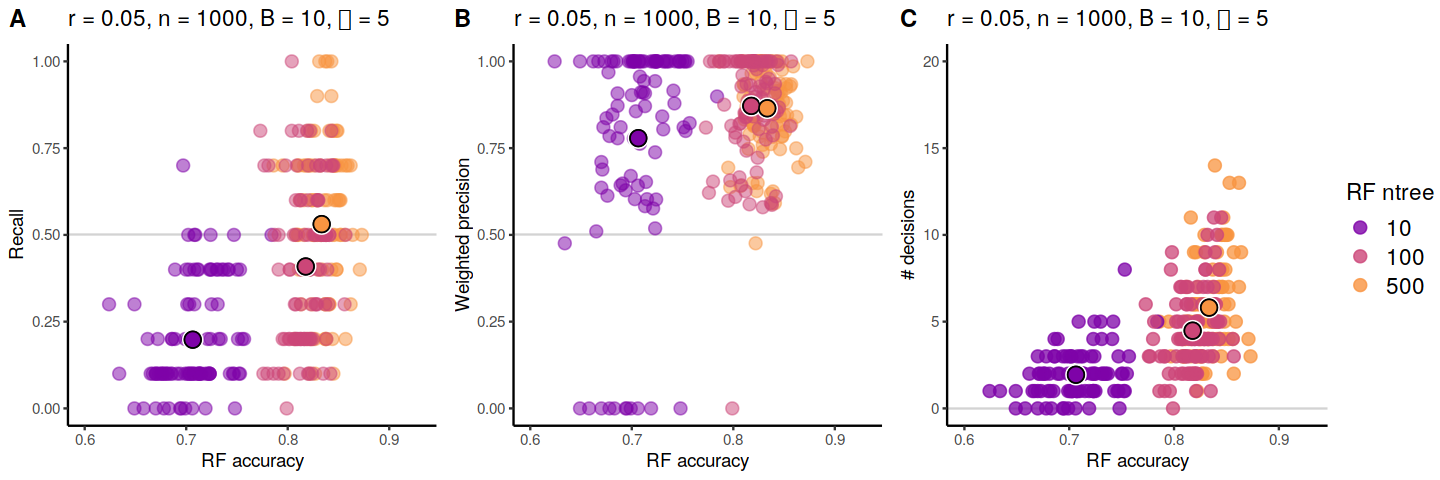

In [18]:
options(repr.plot.width=12, repr.plot.height=4)
pall

# check

In [19]:
res %>% group_by(ntree) %>% summarise_all(mean) %>% 
select(rf_accuracy, n_decisions, tp, fp, fn, tp_imp, fp_imp, precision, recall, w_precision)

rf_accuracy,n_decisions,tp,fp,fn,tp_imp,fp_imp,precision,recall,w_precision
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.70643,1.94,1.98,1.53,6.92,0.5206477,0.05159408,0.5987677,0.198,0.7786993
0.81774,4.48,4.09,3.58,5.81,7.3231019,0.84136874,0.6305150,0.409,0.8717538
0.83344,5.81,5.31,5.24,4.69,42.0865729,5.37720039,0.5767208,0.531,0.8648359


In [20]:
res %>% group_by(ntree) %>% summarise_all(sd)%>% 
select(rf_accuracy, n_decisions, tp, fp, fn, tp_imp, fp_imp, precision, recall, w_precision)

rf_accuracy,n_decisions,tp,fp,fn,tp_imp,fp_imp,precision,recall,w_precision
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.02925722,1.391315,1.563343,2.095956,2.816546,0.5778966,0.08265924,0.3749940,0.1563343,0.3112034
0.01773749,2.311500,2.234238,3.766358,2.272786,5.4789632,0.91184222,0.3119967,0.2234238,0.1567566
0.01662195,2.676856,2.195933,4.653922,2.195933,27.0840586,4.95411285,0.2724472,0.2195933,0.1208653


In [21]:
res %>% select(rf_accuracy, ntree) %>% unique %>% group_by(ntree) %>% summarise_all(mean)
res %>% select(rf_accuracy, ntree) %>% unique %>% group_by(ntree) %>% summarise_all(sd)

ntree,rf_accuracy
<dbl>,<dbl>
10,0.7061818
100,0.8158868
500,0.8328039


ntree,rf_accuracy
<dbl>,<dbl>
10,0.03270329
100,0.02125998
500,0.01965606


In [22]:
cat('Recall:')
tmp <- cor.test(x = res$rf_accuracy, y = res$recall, method = 'pearson')
tmp 
cat('r2 = ', tmp$estimate^2)

Recall:


	Pearson's product-moment correlation

data:  res$rf_accuracy and res$recall
t = 11.758, df = 298, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4803268 0.6356655
sample estimates:
      cor 
0.5629475 


r2 =  0.3169098

In [23]:
cat('Weighted precision:')
tmp <- cor.test(x = res$rf_accuracy, y = res$w_precision, method = 'pearson')
tmp 
cat('r2 = ', tmp$estimate^2)

Weighted precision:


	Pearson's product-moment correlation

data:  res$rf_accuracy and res$w_precision
t = 4.452, df = 298, p-value = 1.204e-05
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1404555 0.3529832
sample estimates:
      cor 
0.2497244 


r2 =  0.06236226

In [24]:
cat('N decisions:')
tmp <- cor.test(x = res$rf_accuracy, y = res$n_decisions, method = 'pearson')
tmp 
cat('r2 = ', tmp$estimate^2)

N decisions:


	Pearson's product-moment correlation

data:  res$rf_accuracy and res$n_decisions
t = 13.65, df = 298, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5453135 0.6853555
sample estimates:
      cor 
0.6202526 


r2 =  0.3847133